<a href="https://colab.research.google.com/github/kobeisfree94/Projects/blob/master/Machine_Translation_Project_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive

drive.mount('/content/drive')

eng_kor = '/content/drive/My Drive/Data AI_BootCamp/DataSets/kor.txt'


data = pd.read_csv(eng_kor, sep='\t', header=None)
data.columns=['eng', 'kor', 'delete']
data.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,eng,kor,delete
0,Go.,가.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,안녕.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Run!,뛰어!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
3,Run.,뛰어.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
4,Who?,누구?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


Preprocessing

In [3]:
# Lowercase
data['eng']= data['eng'].apply(lambda x: x.lower())
data['kor']= data['kor'].apply(lambda x: x.lower())

In [4]:
data= data[['eng', 'kor']]
data.shape

(3798, 2)

In [5]:
# Regex
regex = r"[^a-zA-Z0-9가-힣 ]"

# Substitute
subst = ""


In [6]:
def reg_ex(text):

    tokens = re.sub(regex, subst, text)
    
    return tokens

In [7]:
data['eng_token']= data['eng'].apply(reg_ex)
data['kor_token']= data['kor'].apply(reg_ex)


In [8]:
data = data[['eng_token', 'kor_token']]
data.head(5)

,eng_token,kor_token
0,go,가
1,hi,안녕
2,run,뛰어
3,run,뛰어
4,who,누구


Tokenizer/Embedding/Padding

In [9]:
batch_size = 64
val_split = 0.1
epochs = 2
eng_kor_model = 'model'
maxlen = 100

In [10]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer

In [11]:
def encode_sequences(tokenizer, x):
    seq = tokenizer.texts_to_sequences(x)
    return seq

In [12]:
def pad(x, length):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

In [66]:
#Tokenize English text & determine English Vocab Size 
eng_tok = tokenize(data['eng_token'])
eng_vocab_size = len(eng_tok.word_index) + 1

#Tokenize Korean text & determine Korean Vocab Size 
kor_tok = tokenize(data['kor_token'])
kor_vocab_size = len(kor_tok.word_index) + 1

print(eng_vocab_size)
print(kor_vocab_size)

2590
5767


In [14]:
train_data, test_data = train_test_split(data, random_state =1, train_size = 0.9)
train_data.shape, test_data.shape

((3418, 2), (380, 2))

In [15]:
#Training Data
X_train_token = tokenize(train_data['eng_token'])
X_train_seq = encode_sequences(X_train_token, data['eng_token']) 
y_train_token = tokenize(train_data['kor_token'])
y_train_seq = encode_sequences(y_train_token, data['kor_token'])


train_eng_vocab = len(X_train_token.word_index) + 1
train_kor_vocab = len(y_train_token.word_index) + 1

# Test Data
X_test_token = tokenize(test_data['eng_token'])
X_test_seq = encode_sequences(X_test_token, data['eng_token']) 
y_test_token = tokenize(test_data['kor_token'])
y_test_seq = encode_sequences(y_test_token, data['kor_token'])


test_eng_vocab = len(X_test_token.word_index) + 1
test_kor_vocab = len(y_test_token.word_index) + 1

#Padding Training Data
X_train_pad = pad(X_train_seq, maxlen)
y_train_pad = pad(y_train_seq, maxlen)

#Padding Test Data
X_test_pad = pad(X_test_seq, maxlen)
y_test_pad = pad(y_test_seq, maxlen)

In [16]:
def model(in_vocab, out_vocab, in_timesteps, out_timesteps, batch_size):
    
    model = Sequential()
    model.add(Embedding(in_vocab, batch_size, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(batch_size))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(batch_size, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(out_vocab, activation='softmax'))
    
    return model

In [17]:
#Model
model = model(eng_vocab_size, kor_vocab_size, maxlen, maxlen, batch_size)

#Compile Model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = 'adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           165760    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 repeat_vector (RepeatVector  (None, 100, 64)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 dense (Dense)               (None, 100, 5767)         374855    
                                                                 
Total params: 606,663
Trainable params: 606,663
Non-trainable params: 0
__________________________________________________

In [19]:
#Checkpoint
checkpoint = ModelCheckpoint(eng_kor_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#Train
result = model.fit(X_train_pad, y_train_pad,
                    epochs=epochs, batch_size=batch_size, validation_split = val_split, callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/2
54/54 [==============================] - ETA: 0s - loss: 5.7324
Epoch 1: val_loss improved from inf to 1.44292, saving model to model


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


54/54 [==============================] - 52s 784ms/step - loss: 5.7324 - val_loss: 1.4429
Epoch 2/2
54/54 [==============================] - ETA: 0s - loss: 0.5711
Epoch 2: val_loss improved from 1.44292 to 0.76667, saving model to model


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


54/54 [==============================] - 40s 753ms/step - loss: 0.5711 - val_loss: 0.7667


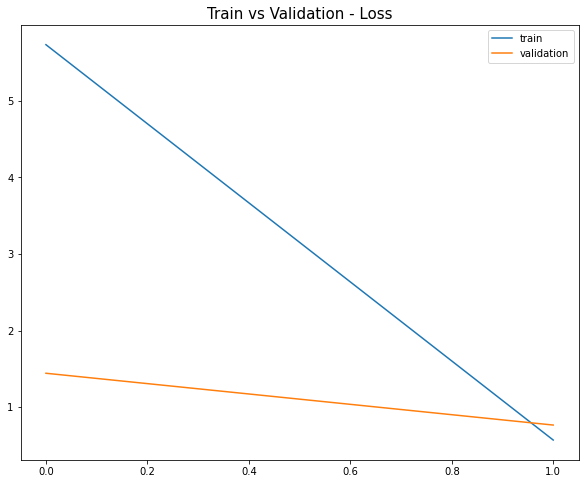

In [20]:
#Train vs. Val Loss 
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['train','validation'])
plt.title("Train vs Validation - Loss", fontsize=15)
plt.show()

In [ ]:
pip install schrutepy

In [28]:
from schrutepy import schrutepy

df = schrutepy.load_schrute()

df.head(5)

,index,season,episode,episode_name,director,writer,character,text,text_w_direction
0,1,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,All right Jim. Your quarterlies look very good...,All right Jim. Your quarterlies look very good...
1,2,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I couldn't close it. So..."
2,3,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,So you've come to the master for guidance? Is ...,So you've come to the master for guidance? Is ...
3,4,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Actually, you called me in here, but yeah.","Actually, you called me in here, but yeah."
4,5,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,"All right. Well, let me show you how it's done.","All right. Well, let me show you how it's done."


In [29]:
df['text']= df['text'].astype(str)

In [30]:
df['text']=df['text'].apply(reg_ex)

In [31]:
df['text']=df['text'].apply(lambda x: x.lower())

In [32]:
test = df['text'].head(1000)

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(test)
word_index= tokenizer.word_index

In [34]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

1908

In [35]:
test_encoded = tokenizer.texts_to_sequences(test)
test_encoded_pad = pad_sequences(test_encoded, maxlen= 100, padding ='post')

In [36]:
predictions = model.predict(test_encoded_pad)

In [75]:
def to_text(logits, tokenizer):

    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = ''
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


In [76]:
print(to_text(predictions, kor_tok))

TypeError: ignored